In [44]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pickle
import photogrammetry as pg

plt.style.use('seaborn-poster')
# plt.style.use('default')
%matplotlib inline
%matplotlib widget

In [33]:
importlib.reload(pg)

<module 'photogrammetry' from '/home/evanmayer/github/hotspot/verification/photogrammetry.py'>

In [34]:
# check for pickled camera matrices to avoid expensive recalibration
if not (
    os.path.exists('camera_cal_mtx.pickle') and
    os.path.exists('camera_cal_dist.pickle') and
    os.path.exists('camera_cal_optimal_camera_matrix.pickle')
):
    # calibrate the camera for distortion
    mtx, dist, optimal_camera_matrix, roi = pg.calibrate_camera(
        os.path.join('input', 'camera_cal'),
        method='charuco',
        plot=False
    )
    with open('camera_cal_mtx.pickle', 'wb') as f:
        pickle.dump(mtx, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('camera_cal_dist.pickle', 'wb') as f:
        pickle.dump(dist, f, protocol=pickle.HIGHEST_PROTOCOL)
    with open('camera_cal_optimal_camera_matrix.pickle', 'wb') as f:
        pickle.dump(optimal_camera_matrix, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('camera_cal_mtx.pickle', 'rb') as f:
        mtx = pickle.load(f)
    with open('camera_cal_dist.pickle', 'rb') as f:
        dist = pickle.load(f)
    with open('camera_cal_optimal_camera_matrix.pickle', 'rb') as f:
        optimal_camera_matrix = pickle.load(f)

In [39]:
importlib.reload(pg)
image_data_charuco = pg.find_targets(
    os.path.join('input', 'meas', '18x18_.2x.2_20220721_r1'),
    os.path.join('input', 'targets'),
    mtx,
    dist,
    optimal_camera_matrix,
    stride=1,
    plot=False
)

INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/102.jpg: True
INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/104.jpg: True
INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/109.jpg: True
INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/101.jpg: True
INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/103.jpg: True
INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/108.jpg: True
INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/1.jpg: True
INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/106.jpg: True
INFO:photogrammetry:Corner detection after de-distortion in input/meas/18x18_.2x.2_20220721_r1/10.jpg: True
INFO:photogrammetry:Co

In [40]:
# plt.close('all')

In [41]:
# print(image_data_charuco)

11 x-measurements with >3x RMSE ignored (highlighted red).
11 y-measurements with >3x RMSE ignored (highlighted red).


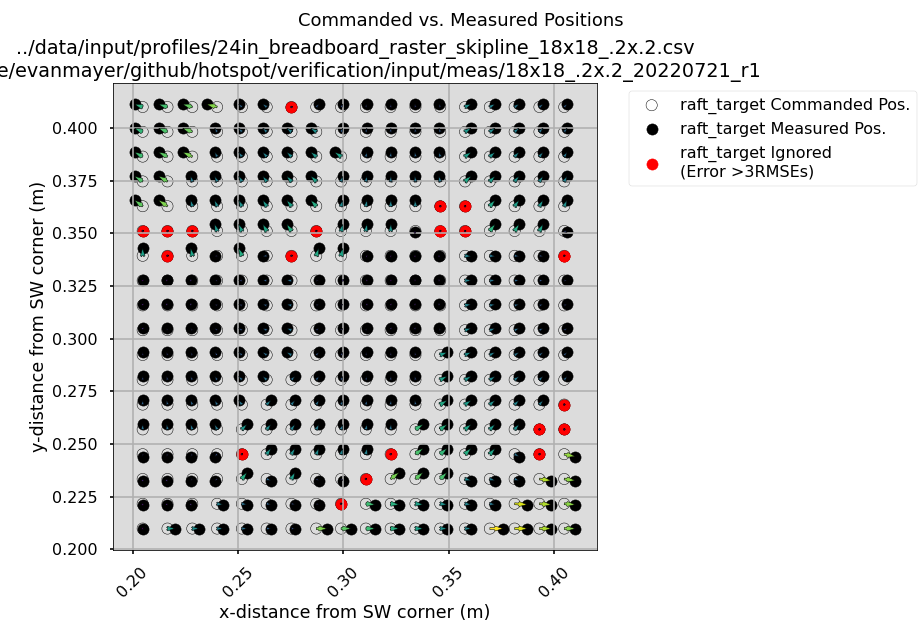

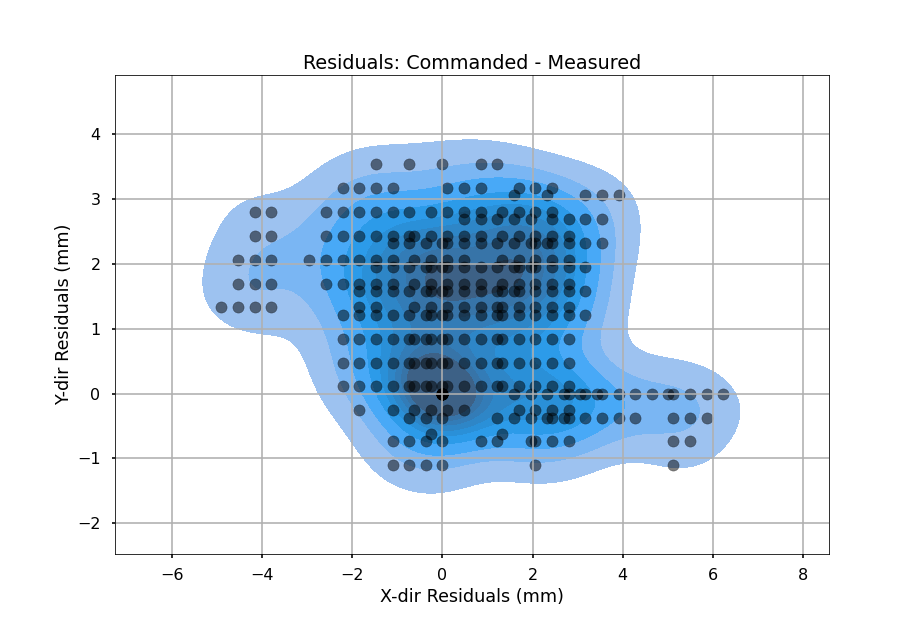

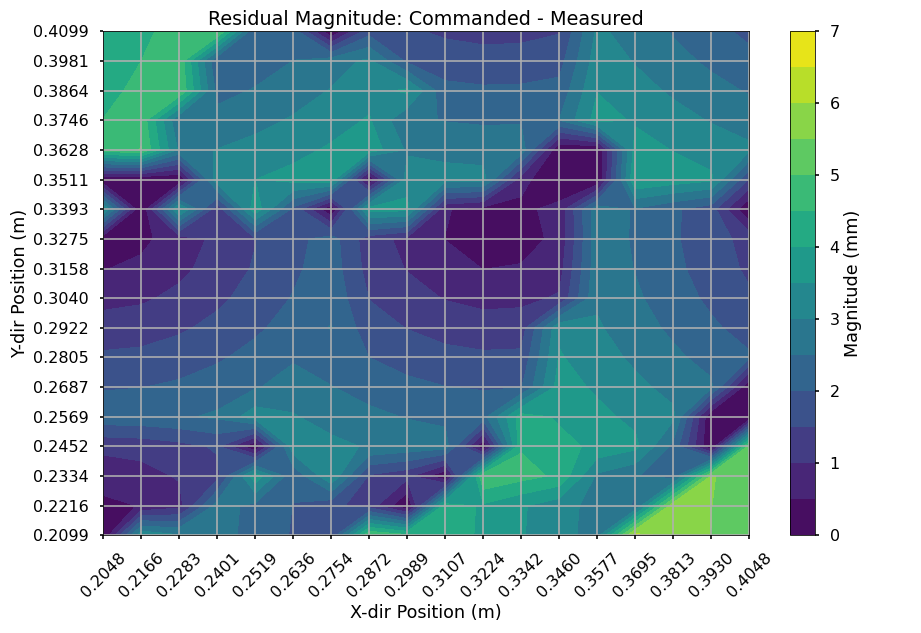

In [46]:
importlib.reload(pg)
command_file = os.path.join('..', 'data', 'input', 'profiles', '24in_breadboard_raster_skipline_18x18_.2x.2.csv')
pg.post_process_many_to_many(image_data_charuco, command_file)#, ref='SW', SW_offset=(.05822, .18449))
# pg.post_process_many_to_one(image_data_charuco)

In [ ]:
# with open('output/18x18_.2x.2_20220721_r1_location_data.json', mode='w') as f:
#     s = json.dumps(image_data_charuco)
#     f.write(s)

In [30]:
pixel_scales = []
for img, img_data in image_data_charuco.items():
    if os.path.exists(img):
        pixel_scales.append(img_data['px_per_m'])


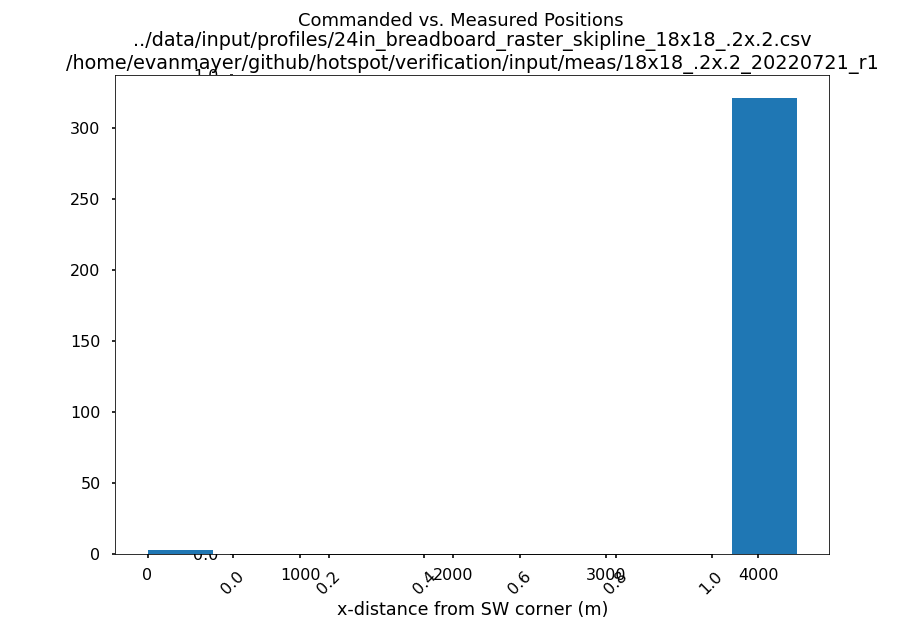

In [31]:
ax = plt.axes()
ax.hist(pixel_scales)
plt.show()